# **Cassava Leaf Disease Classification: Transfer Learning with VGG and Keras Baseline**
![Cassava](https://scx2.b-cdn.net/gfx/news/2019/3-geneeditingt.jpg)

This kernel is based on the following kernel: 

* [Cassava Leaf Disease:Keras CNN baseline](https://www.kaggle.com/maksymshkliarevskyi/cassava-leaf-disease-keras-cnn-baseline)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16
from sklearn.utils import class_weight

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

In [2]:
print(('Is your GPU available for use?\n{0}').format(
    'Yes, your GPU is available: True' if tf.test.is_gpu_available() == True else 'No, your GPU is NOT available: False'
))

print(('\nYour devices that are available:\n{0}').format(
    [device.name for device in tf.config.experimental.list_physical_devices()]
))


Is your GPU available for use?
Yes, your GPU is available: True

Your devices that are available:
['/physical_device:CPU:0', '/physical_device:XLA_CPU:0', '/physical_device:GPU:0', '/physical_device:XLA_GPU:0']


## Setting the working directory

In [3]:
WORK_DIR = '../input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

# Getting a peek at the data

In [4]:
list_dir = os.listdir(os.path.join(WORK_DIR, "train_images"))
print(list_dir[0:5])

['1235188286.jpg', '1215607589.jpg', '478554372.jpg', '2763304605.jpg', '2826122413.jpg']


In [5]:
print(len(list_dir))

21397


There are 21297 images.

In [6]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=2))

{
  "0": "Cassava Bacterial Blight (CBB)",
  "1": "Cassava Brown Streak Disease (CBSD)",
  "2": "Cassava Green Mottle (CGM)",
  "3": "Cassava Mosaic Disease (CMD)",
  "4": "Healthy"
}


The number of classes in the output variable is 5, four is for disease and one for healthy.

In [7]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

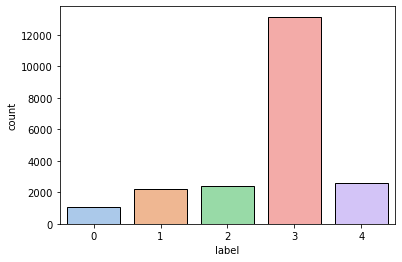

In [8]:
sns.countplot(train_labels.label, edgecolor = 'black',
              palette = sns.color_palette("pastel", 5))
plt.show()

From the above graph we have an imbalanced dataset. 

In [9]:
sample = train_labels[train_labels.label == 3].sample(1)
image = cv2.imread(os.path.join(WORK_DIR, "train_images", sample.iloc[0,0]))
print(image.shape)

(600, 800, 3)


The images have color images and have dimensions of 600x800.

Some photos of "0": "Cassava Bacterial Blight (CBB)

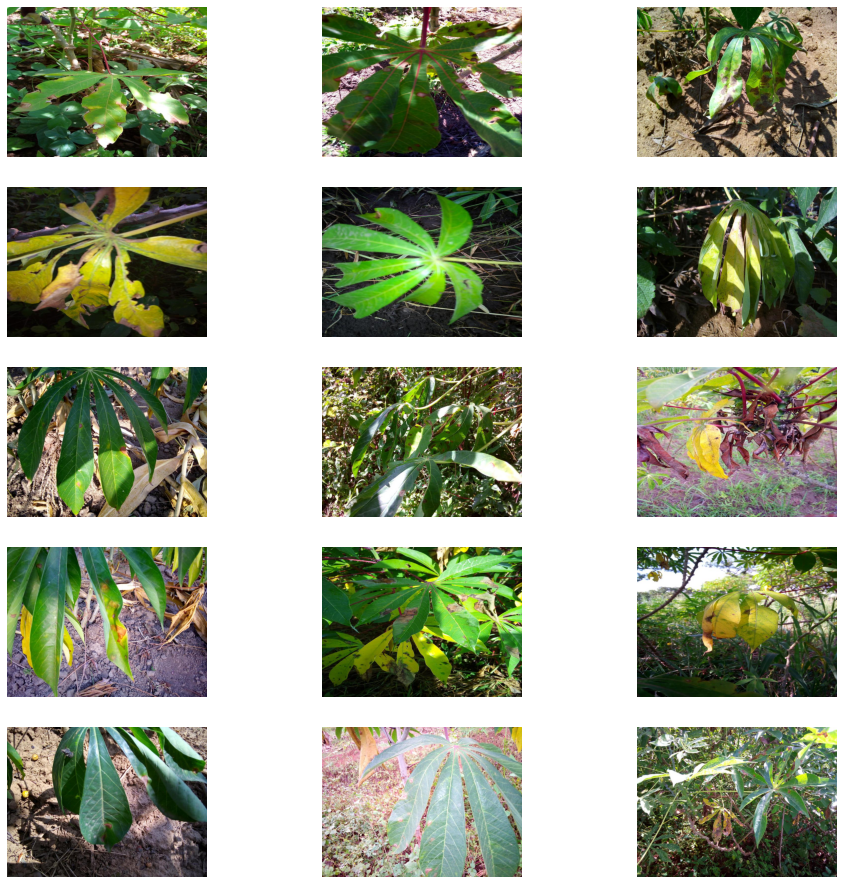

In [10]:
sample = train_labels[train_labels.label == 0].sample(15)
plt.figure(figsize=(16, 16))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(5, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

Some photos of "1": "Cassava Brown Streak Disease (CBSD)"

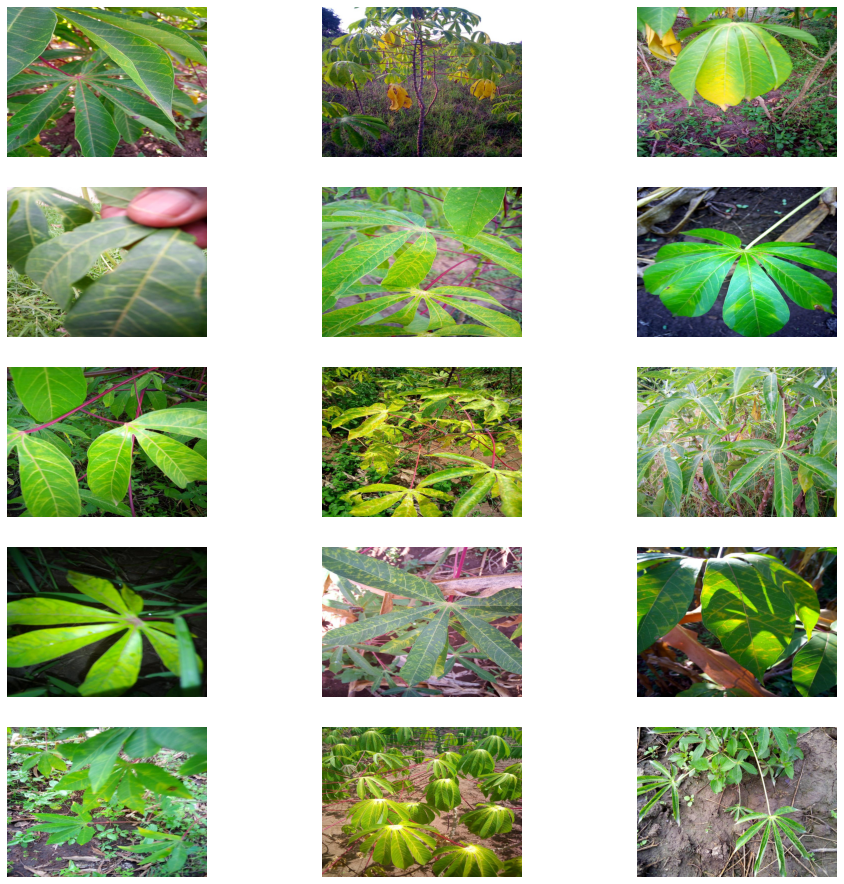

In [11]:
sample = train_labels[train_labels.label == 1].sample(15)
plt.figure(figsize=(16, 16))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(5, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

Some photos of "2": "Cassava Green Mottle (CGM)"

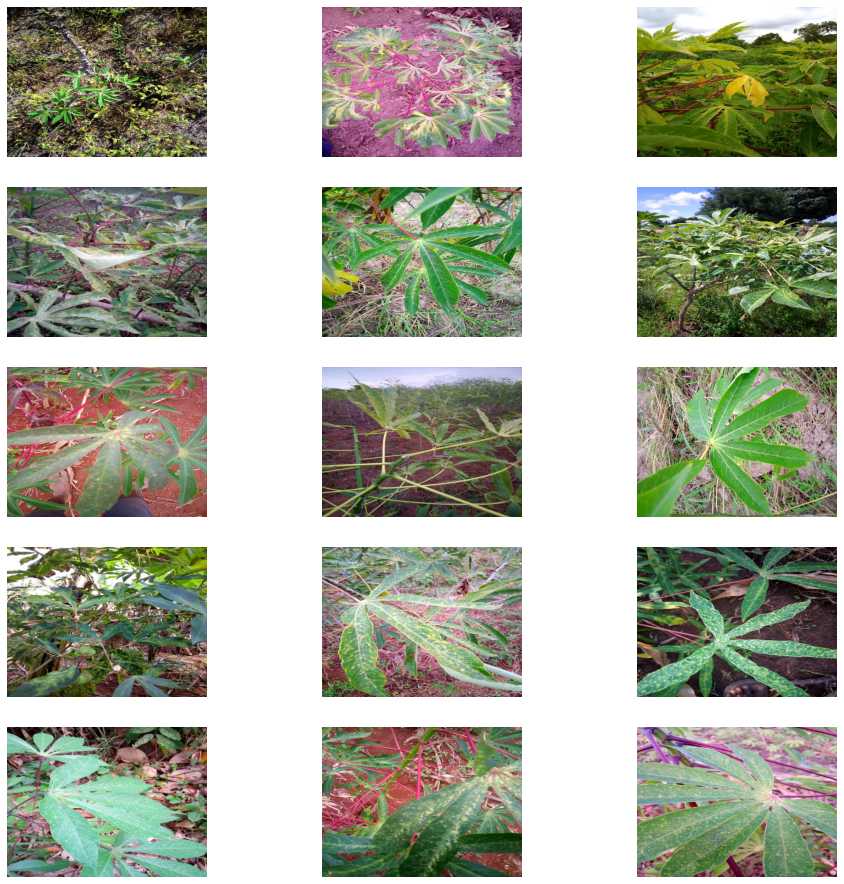

In [12]:
sample = train_labels[train_labels.label == 2].sample(15)
plt.figure(figsize=(16, 16))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(5, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

Some photos of "3": "Cassava Mosaic Disease (CMD)"

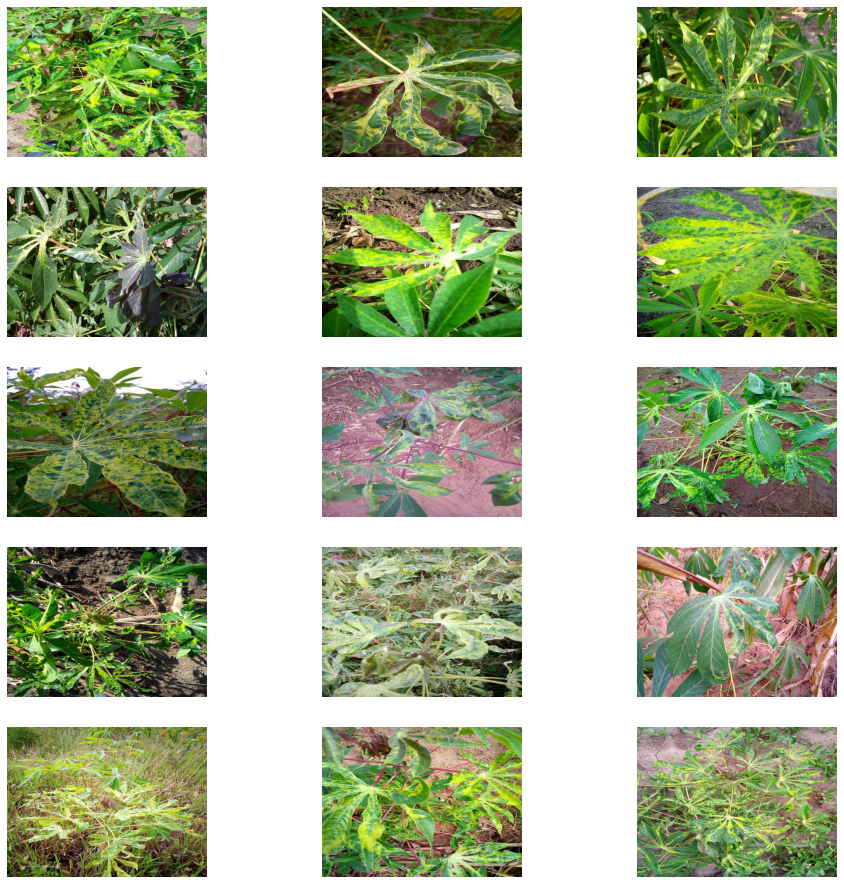

In [13]:
sample = train_labels[train_labels.label == 3].sample(15)
plt.figure(figsize=(16, 16))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(5, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

Some photos of "4": "Healthy"

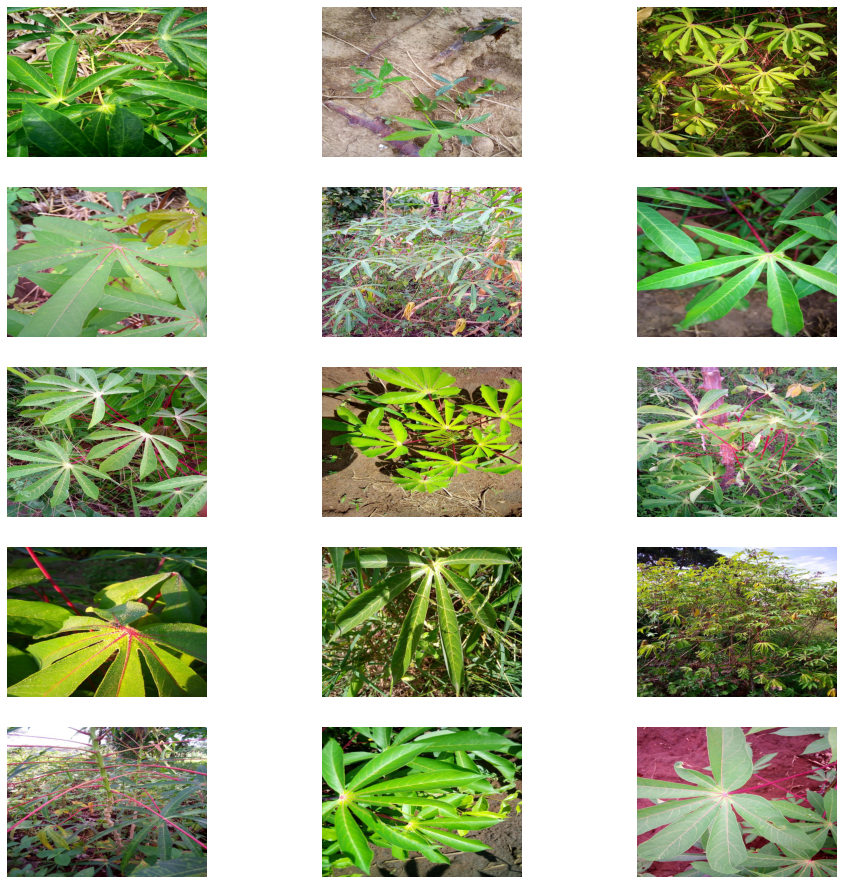

In [14]:
sample = train_labels[train_labels.label == 4].sample(15)
plt.figure(figsize=(16, 16))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(5, 3, ind + 1)
    image = cv2.imread(os.path.join(WORK_DIR, "train_images", image_id))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    
plt.show()

# Modeling

In [15]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 10
TARGET_SIZE = 224

In [16]:
train_labels.label = train_labels.label.astype('str')

train_gen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     zoom_range = 0.2,
                                     cval = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.2,
                                     height_shift_range = 0.2,
                                     width_shift_range = 0.2, 
                                     rescale=1.0/255.0) 

valid_gen = ImageDataGenerator(validation_split=0.2, rescale=1.0/255.0) 

In [17]:



train_it = train_gen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

valid_it = valid_gen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [18]:
def create_model():
        
    # Good resource 
    # https://androidkt.com/how-to-use-vgg-model-in-tensorflow-keras/
    
    vgg16_model = VGG16(include_top=False, input_shape=(TARGET_SIZE, TARGET_SIZE, 3), weights='imagenet' )
                  
    vgg16_model.trainable=False                
    
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()              
                  
    prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
    
    model = tf.keras.Sequential([vgg16_model,
                                 global_average_layer,
                                 prediction_layer
                                 ])
    
    
    
    opt = Adam(lr = 0.0001)
    
    # The following resource was very helpful to 
    # treat the imbalanced class problem. 
    # https://medium.com/@markryan_69718/what-to-do-when-the-labels-are-skewed-tackling-the-accuracy-paradox-7b72bd4a9ccc
        
    
    
    model.compile(optimizer = opt ,
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"], 
                  weighted_metrics=["accuracy"]
                 )
    return model

In [19]:
model = create_model()
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels.label),
                                                 train_labels.label)


labels = []

for i in range(len(np.unique(train_labels.label))):
    labels.append(i)
    
    

dict_class_weights = dict(zip(labels, class_weights.tolist())) 


history = model.fit_generator(
    train_it,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = valid_it,
    validation_steps = VALIDATION_STEPS,
    class_weight=dict_class_weights
)

Epoch 1/20
535/534 [==============================] - 443s 828ms/step - loss: 1.4668 - acc: 0.5039 - accuracy: 0.3582 - val_loss: 1.2326 - val_acc: 0.4985 - val_accuracy: 0.4985
Epoch 2/20
535/534 [==============================] - 354s 661ms/step - loss: 1.3628 - acc: 0.5474 - accuracy: 0.4244 - val_loss: 1.1502 - val_acc: 0.5627 - val_accuracy: 0.5627
Epoch 3/20
535/534 [==============================] - 351s 656ms/step - loss: 1.3212 - acc: 0.5591 - accuracy: 0.4502 - val_loss: 1.2280 - val_acc: 0.4964 - val_accuracy: 0.4964
Epoch 4/20
535/534 [==============================] - 354s 661ms/step - loss: 1.2958 - acc: 0.5636 - accuracy: 0.4677 - val_loss: 1.0996 - val_acc: 0.5959 - val_accuracy: 0.5959
Epoch 5/20
535/534 [==============================] - 352s 658ms/step - loss: 1.2808 - acc: 0.5758 - accuracy: 0.4816 - val_loss: 1.1214 - val_acc: 0.5700 - val_accuracy: 0.5700
Epoch 6/20
535/534 [==============================] - 353s 660ms/step - loss: 1.2705 - acc: 0.5786 - accuracy:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [ ]:
model.save('./baseline_model.h5')

# Predict

In [ ]:
ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss

In [ ]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

ss['label'] = preds
ss

In [ ]:
ss.to_csv('submission.csv', index = False)